# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import matplotlib.pyplot as plt	
	
def display(test_x, test_y, model):
    hit = 0
    total = 0
    results = []
    for idx in range(len(test_x)):
        actual = test_y[idx]
        predicted = model.predict(test_x[idx].reshape(1,-1))
        total += 1
        #print(f"[{idx:02d}] actual={actual}, predicted={predicted} - {actual==predicted}")
        if actual == predicted[0]:
            results.append(True)
            hit += 1
        else:
            results.append(False)

    print(f"Accuracy: {hit/total} ({hit}/{total})")
    
    return results
	
	
def simulate(file_name, nan_cnt, empty_policy, models, show_plot = True):

    print(f"filename:{file_name}\nnan_cnt:{nan_cnt}\nempty_policy:{empty_policy}\n")
    
    # load csv file
    df_data = pd.read_csv(file_name)

    # Feature engineering
    isna_dict = dict(df_data.isna().sum())
    isna_keys = list(isna_dict.keys())
    del_column_idx = []
    del_column_names = []
    for idx, cnt in enumerate(isna_dict.values()):
        if cnt >= nan_cnt:
            #print(idx, cnt, isna_keys[idx])
            del_column_idx.append(idx)
            del_column_names.append(isna_keys[idx])
			
    df_data = df_data.drop(del_column_names, axis=1)
    df_data.describe()
    
    # conver dataframe to nparray
    ips_data = np.array(df_data)


    # calcuate min, avg for each wifi

    wifi_ap_rssis_dict = {}
    for row in ips_data:
        for idx, rssi in enumerate(row[4:]):
            mac = df_data.columns[4+idx]
            if mac not in wifi_ap_rssis_dict.keys():
                wifi_ap_rssis_dict[mac] = {'values':[]}
            if math.isnan(rssi) is False:
                wifi_ap_rssis_dict[mac]['values'].append(rssi)

	# wifi_ap_rssis_dict = { mac: {"values":[]}}
	# k is mac
	# v is {'values'}
			   
    for v in wifi_ap_rssis_dict.values():
        v['avg'] = sum(v['values'])/len(v['values'])
        v['min'] = min(v['values'])
        v['default'] = -120    


    # fill empty data

    if empty_policy not in ['min', 'avg', 'default']:
        empty_policy = 'default'


    for row in ips_data:
        for idx in range(len(row[4:])):
            col = 4+idx
            mac = df_data.columns[col]
            rssi = row[col]
            if math.isnan(rssi) == True:
                row[col] = wifi_ap_rssis_dict[mac][empty_policy]


    # prepare training data

    ips_x = ips_data[:, 4:]
    ips_y = ips_data[:, 1:2]
    ips_y = ips_y.reshape(-1)
    ips_y = ips_y.astype(np.int32)



    train_x, test_x, train_y, test_y = model_selection.train_test_split(ips_x, ips_y, test_size=0.3, shuffle=False)

    print("x_train:", train_x.shape, "y_train:", train_y.shape)
    print("x_test: ", test_x.shape, "y_test: ", test_y.shape)
    print()

    latitudes = ips_data[72:, 2:3]
    latitudes = latitudes.reshape(-1)
    longitudes = ips_data[72:, 3:4]
    longitudes = longitudes.reshape(-1)
    
    report_dict = {"model_acc":{}}
    for model in models:
        model.fit(train_x, train_y)    # 모델 학습
        print(model)
        print("score:", model.score(test_x, test_y))

        results = display(test_x, test_y, model)
        colors = ['blue' if r == True else 'red' for r in results]

        if show_plot == True:
            plt.scatter(latitudes, longitudes, c=colors)
            plt.show()

        report_dict['model_acc'][str(model)] = model.score(test_x, test_y)

    
    return report_dict

    

filename:trace.csv
nan_cnt:30
empty_policy:min

x_train: (72, 14) y_train: (72,)
x_test:  (31, 14) y_test:  (31,)

KNeighborsClassifier()
score: 0.3870967741935484
Accuracy: 0.3870967741935484 (12/31)


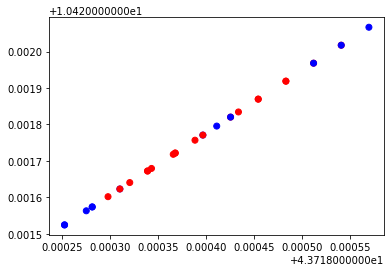

SVC()
score: 0.5806451612903226
Accuracy: 0.5806451612903226 (18/31)


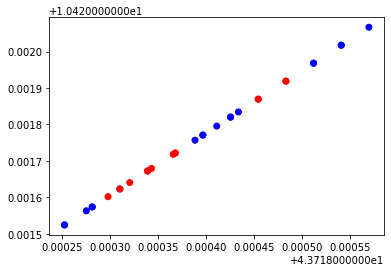

{'model_acc': {'KNeighborsClassifier()': 0.3870967741935484,
  'SVC()': 0.5806451612903226}}

In [2]:
simulate(file_name="trace.csv", nan_cnt=30, empty_policy='min', models=[KNeighborsClassifier(), svm.SVC() ])

In [3]:
# for 문을 활용하여 파라미터 값을 변경한다면?

In [4]:
report = []
best_acc = 0
best_acc_condition = ""

for nan_cnt in [10,20,30,40,50,60,70,80]:
    for empty_policy in ['min', 'avg', 'default']:
        r = simulate(file_name="trace.csv", nan_cnt=nan_cnt, empty_policy=empty_policy, models=[KNeighborsClassifier(), svm.SVC()], show_plot=False)
        r['nan_cnt'] = nan_cnt
        r['empty_policy'] = empty_policy
        report.append(r)
        print()
    
print(f"{'model':25s}, {'nan_cnt':7s}, {'empty_policy':13s}, {'acc(%)':7s}")
print("--------------------------------------------")
for r in report:
    for model, acc in r['model_acc'].items():
        print(f"{model:25s}, {r['nan_cnt']:7d}, {r['empty_policy']:13s}, {acc*100:6.2f}%")
        if acc > best_acc:
            best_acc = acc
            best_acc_condition = r
            
print(f"best acc: {best_acc*100:.2f}%\n@{str(best_acc_condition)}") 
    

filename:trace.csv
nan_cnt:10
empty_policy:min

x_train: (72, 11) y_train: (72,)
x_test:  (31, 11) y_test:  (31,)

KNeighborsClassifier()
score: 0.5161290322580645
Accuracy: 0.5161290322580645 (16/31)
SVC()
score: 0.5483870967741935
Accuracy: 0.5483870967741935 (17/31)

filename:trace.csv
nan_cnt:10
empty_policy:avg

x_train: (72, 11) y_train: (72,)
x_test:  (31, 11) y_test:  (31,)

KNeighborsClassifier()
score: 0.3548387096774194
Accuracy: 0.3548387096774194 (11/31)
SVC()
score: 0.5161290322580645
Accuracy: 0.5161290322580645 (16/31)

filename:trace.csv
nan_cnt:10
empty_policy:default

x_train: (72, 11) y_train: (72,)
x_test:  (31, 11) y_test:  (31,)

KNeighborsClassifier()
score: 0.5161290322580645
Accuracy: 0.5161290322580645 (16/31)
SVC()
score: 0.5161290322580645
Accuracy: 0.5161290322580645 (16/31)

filename:trace.csv
nan_cnt:20
empty_policy:min

x_train: (72, 14) y_train: (72,)
x_test:  (31, 14) y_test:  (31,)

KNeighborsClassifier()
score: 0.3870967741935484
Accuracy: 0.3870967

In [5]:
from sklearn.gaussian_process import GaussianProcessClassifier
model = GaussianProcessClassifier() # 모델 생성
model.fit(train_x, train_y)    # 모델 학습

NameError: name 'train_x' is not defined

In [ ]:
model.score(test_x, test_y)